In [22]:
# Install necessary libraries
! pip install torch numpy pandas scikit-learn



In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader


In [24]:
data = pd.read_csv("loan_data.csv")

# Convert categorical variables
data = pd.get_dummies(data, columns=["person_gender", "person_education", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file"], drop_first=True)

# Define features & target
X = data.drop(columns=["loan_status"])
y = data["loan_status"].values  

# Train-test-validation split (70% train, 15% val, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

# DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)


In [25]:
class LorentzianNN(nn.Module):
    def __init__(self, input_dim):
        super(LorentzianNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 2)

        self.dropout = nn.Dropout(0.3)

    def lorentzian_activation(self, x):
        return 1 / (1 + x ** 2)

    def forward(self, x):
        x = self.lorentzian_activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.lorentzian_activation(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.lorentzian_activation(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.lorentzian_activation(self.fc4(x))
        x = self.fc5(x)
        return x


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LorentzianNN(input_dim=X_train.shape[1]).to(device)

# Handle class imbalance
class_counts = np.bincount(y_train.numpy())
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)


In [27]:
num_epochs = 25
best_val_loss = float("inf")
patience, patience_counter = 3, 0

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss, train_correct, total_train = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        train_correct += (output.argmax(dim=1) == y_batch).sum().item()
        total_train += X_batch.size(0)

    train_loss /= total_train
    train_acc = train_correct / total_train

    model.eval()
    val_loss, val_correct, total_val = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            val_correct += (output.argmax(dim=1) == y_batch).sum().item()
            total_val += X_batch.size(0)

    val_loss /= total_val
    val_acc = val_correct / total_val

    print(f"Epoch {epoch}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


Epoch 1/25 | Train Loss: 0.6959 | Train Acc: 0.5463 | Val Loss: 0.6953 | Val Acc: 0.7778
Epoch 2/25 | Train Loss: 0.6941 | Train Acc: 0.5669 | Val Loss: 0.6910 | Val Acc: 0.7930
Epoch 3/25 | Train Loss: 0.5321 | Train Acc: 0.7145 | Val Loss: 0.2801 | Val Acc: 0.8357
Epoch 4/25 | Train Loss: 0.3141 | Train Acc: 0.8525 | Val Loss: 0.2539 | Val Acc: 0.8686
Epoch 5/25 | Train Loss: 0.2866 | Train Acc: 0.8603 | Val Loss: 0.2416 | Val Acc: 0.8745
Epoch 6/25 | Train Loss: 0.2764 | Train Acc: 0.8617 | Val Loss: 0.2446 | Val Acc: 0.8699
Epoch 7/25 | Train Loss: 0.2655 | Train Acc: 0.8661 | Val Loss: 0.2384 | Val Acc: 0.8796
Epoch 8/25 | Train Loss: 0.2619 | Train Acc: 0.8743 | Val Loss: 0.2377 | Val Acc: 0.8720
Epoch 9/25 | Train Loss: 0.2612 | Train Acc: 0.8747 | Val Loss: 0.2353 | Val Acc: 0.8840
Epoch 10/25 | Train Loss: 0.2577 | Train Acc: 0.8716 | Val Loss: 0.2331 | Val Acc: 0.8799
Epoch 11/25 | Train Loss: 0.2521 | Train Acc: 0.8744 | Val Loss: 0.2315 | Val Acc: 0.8582
Epoch 12/25 | Train

In [28]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_loss, test_correct, total_test = 0, 0, 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        loss = criterion(output, y_batch)

        test_loss += loss.item() * X_batch.size(0)
        test_correct += (output.argmax(dim=1) == y_batch).sum().item()
        total_test += X_batch.size(0)

test_loss /= total_test
test_acc = test_correct / total_test
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Test Loss: 0.2305 | Test Acc: 0.8724


In [33]:
model.eval()


LorentzianNN(
  (fc1): Linear(in_features=22, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [36]:
! pip install matplotlib

  Using cached matplotlib-3.10.1-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp311-cp311-win_amd64.whl.metadata (103 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.1.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp311-cp311-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl (219 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp311-cp311-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl (71 kB)
Using cached pillow-11.1.0-cp311-cp311-win_amd64.whl (2.6 MB)
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)


In [38]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss curves
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r*-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r*-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()


Epoch 1/25, Train Loss: 0.2377, Val Loss: 0.2238, Train Acc: 87.66%, Val Acc: 87.45%
Epoch 2/25, Train Loss: 0.2363, Val Loss: 0.2273, Train Acc: 88.15%, Val Acc: 89.29%
Epoch 3/25, Train Loss: 0.2343, Val Loss: 0.2247, Train Acc: 88.30%, Val Acc: 88.31%
Epoch 4/25, Train Loss: 0.2359, Val Loss: 0.2243, Train Acc: 88.06%, Val Acc: 88.18%
Epoch 5/25, Train Loss: 0.2357, Val Loss: 0.2228, Train Acc: 88.15%, Val Acc: 89.32%
Epoch 6/25, Train Loss: 0.2335, Val Loss: 0.2233, Train Acc: 88.41%, Val Acc: 87.82%
Epoch 7/25, Train Loss: 0.2346, Val Loss: 0.2242, Train Acc: 87.72%, Val Acc: 88.77%
Epoch 8/25, Train Loss: 0.2324, Val Loss: 0.2235, Train Acc: 88.06%, Val Acc: 88.83%
Epoch 9/25, Train Loss: 0.2322, Val Loss: 0.2233, Train Acc: 87.91%, Val Acc: 88.24%
Epoch 10/25, Train Loss: 0.2310, Val Loss: 0.2262, Train Acc: 88.03%, Val Acc: 89.21%
Epoch 11/25, Train Loss: 0.2330, Val Loss: 0.2232, Train Acc: 88.08%, Val Acc: 88.04%
Epoch 12/25, Train Loss: 0.2292, Val Loss: 0.2215, Train Acc: 8

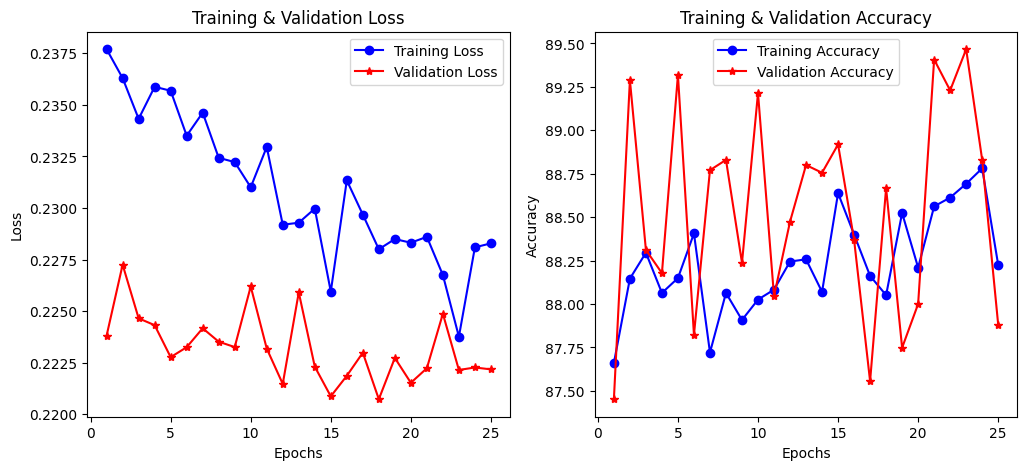

In [39]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")

# Plot curves
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
